In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_csv('../../data/processed/openfoodfacts_filtered.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   nutriscore_grade                      250000 non-null  object 
 1   code                                  250000 non-null  object 
 2   product_name                          245761 non-null  object 
 3   brands                                197024 non-null  object 
 4   categories                            249837 non-null  object 
 5   countries                             249365 non-null  object 
 6   energy_100g                           245665 non-null  float64
 7   energy-kcal_100g                      239065 non-null  float64
 8   fat_100g                              245656 non-null  float64
 9   saturated-fat_100g                    239766 non-null  float64
 10  carbohydrates_100g                    245330 non-null  float64
 11  

# Target Analysis

Let's analize the plotting of the target variable `nutriscore_grade`

Text(0.5, 1.0, 'Distribution of Target Variable')

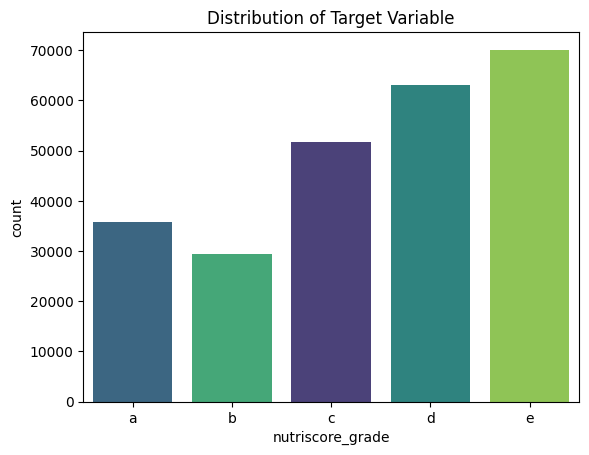

In [5]:
sns.countplot(data=df, x='nutriscore_grade',order=sorted(
    df['nutriscore_grade'].unique()), 
    palette='viridis',
    hue='nutriscore_grade'
    )

plt.title('Distribution of Target Variable')

The `nutriscore_grade` is divided into 5 different classes `[A, B, C, D, E]`. The most frequent is **E**, representing the worst nutriscore. The least frequent is **B**.

# Missing Values Analysis

We plot the **missing percentage** of values for each category of the dataset

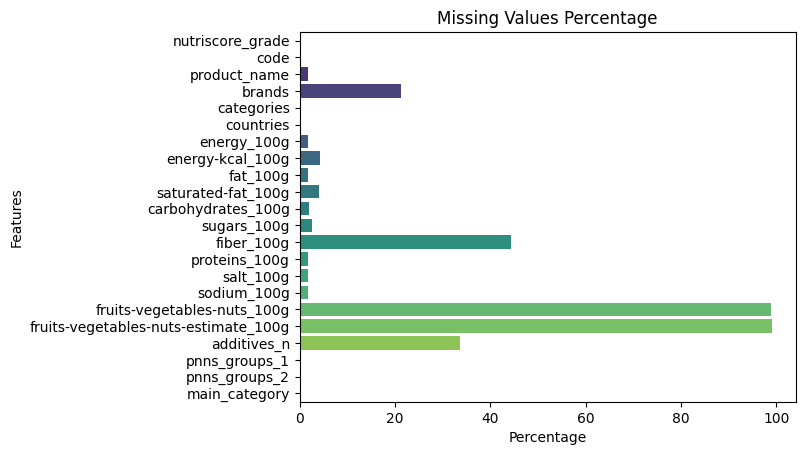

In [6]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
sns.barplot(y=missing_percentage.index,
            x=missing_percentage.values, 
            palette='viridis',
            orient='h',
            hue=missing_percentage.index,
            legend=False)

plt.title('Missing Values Percentage')
plt.xlabel('Percentage')
plt.ylabel('Features')
plt.show()


Two of the features, `fruits-vegetables-nuts` and `fruits-vegetables-nuts-estimate` have more than **95 percent** of missing value.

Also `fiber` and `additives` have a considerable amount of missing values.

A removal or a correct inputation strategy is required.

In [7]:
#df.drop(columns=['fruits-vegetables-nuts_100g','fruits-vegetables-nuts-estimate_100g'], inplace=True)

# Numerical Feature Analysis

## Skewness Analysis

We now plot the **skewness** for each numerical column to see if some problem emerge. A very high skewness can help us identify problems in the data.

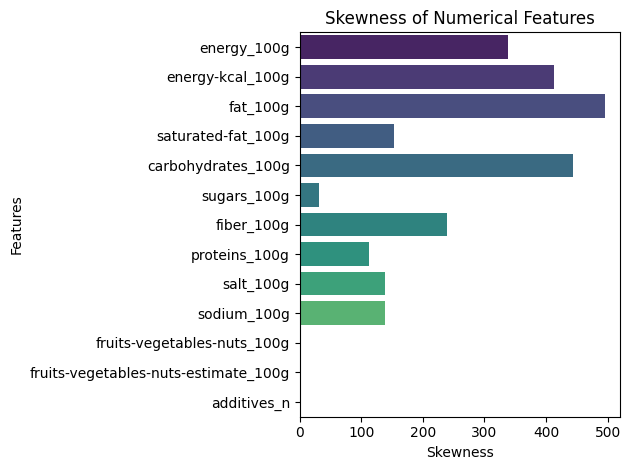

In [8]:
numerical_features = df.select_dtypes(include=[np.number]).columns

sns.barplot(y=numerical_features,
            x=df[numerical_features].skew(),
            palette='viridis',
            orient='h',
            hue=numerical_features,
            legend=False)

plt.title('Skewness of Numerical Features')
plt.xlabel('Skewness')
plt.ylabel('Features')
plt.tight_layout()
plt.show()




### Check on the values
There are some feature with a very high skew value.
The high skewness is probabily due to to wrong inputs in the dataset, let's check by looking at the highest values of the features to check if they're coherent.

In [9]:
df_numeric = df[numerical_features]
display(df_numeric.max())

energy_100g                            2305554.00
energy-kcal_100g                       3701123.00
fat_100g                                678454.00
saturated-fat_100g                        4878.00
carbohydrates_100g                       84878.00
sugars_100g                               4878.00
fiber_100g                                4848.00
proteins_100g                             4848.00
salt_100g                                10740.00
sodium_100g                               4296.00
fruits-vegetables-nuts_100g                100.00
fruits-vegetables-nuts-estimate_100g       100.00
additives_n                                 47.00
dtype: float64

Like we thought there is an **incongruence** in the data. It can't be possible to have values as high as 938364 for `fiber_100g`. Since the dataset we chose is made by unverified data input by web users, we are bound to have some problems. 

For the sake of this Exploratory Data Analysis and better plotting for now we remove data that we think are **invalid or out of range**.

With the following code we proceed to filter the data.

In [10]:
valid_ranges = {
    'fat_100g': (0, 100),
    'saturated-fat_100g': (0, 100),
    'carbohydrates_100g': (0, 100),
    'sugars_100g': (0, 100),
    'fiber_100g': (0, 100),
    'proteins_100g': (0, 100),
    'salt_100g': (0, 100),
    'energy_100g': (0, 5000),
    'energy-kcal_100g': (0,1000)
}

print(f"Rows pre-cleaning: {df.shape[0]}")

for col, (min_val, max_val) in valid_ranges.items():
    if col in df.columns:
        is_error = (df[col] < min_val) | (df[col] > max_val)
        df = df[~is_error]

print(f"Rows post-cleaning: {df.shape[0]}")

Rows pre-cleaning: 250000
Rows post-cleaning: 246279


We removed 1500 invalid values. Out of 100k it is an acceptable number, a better outlier removal will be implemented in the preprocesing

We can now plot the skewness of the features without out of range and invalid values.

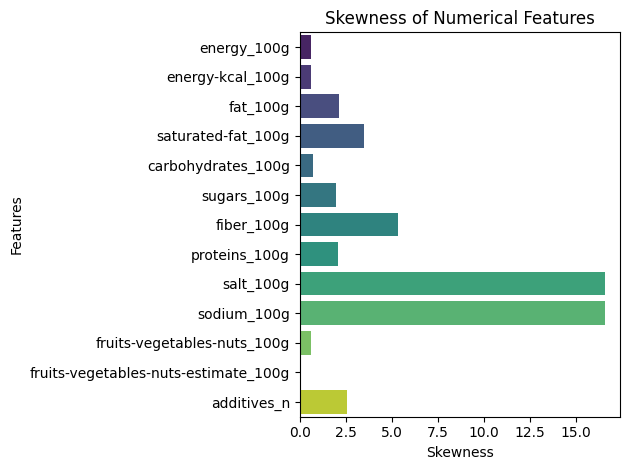

In [11]:


numerical_features = df.select_dtypes(include=[np.number]).columns

sns.barplot(y=numerical_features, x=df[numerical_features].skew(),
            palette='viridis',orient='h',hue=numerical_features,
            legend=False)

plt.title('Skewness of Numerical Features')
plt.xlabel('Skewness')
plt.ylabel('Features')
plt.tight_layout()
plt.show()




After the invalid values removal we obtain better results, `Salt` and `Sodium` will probabilly be the same. The features with the highest skewness are salt and sodium. 
Chemically speaking salt is made out of sodium so this plot is expected. The high skewness in this column means that probabilly there are a lot of **0** and some high value that can
generated a long right tail. 

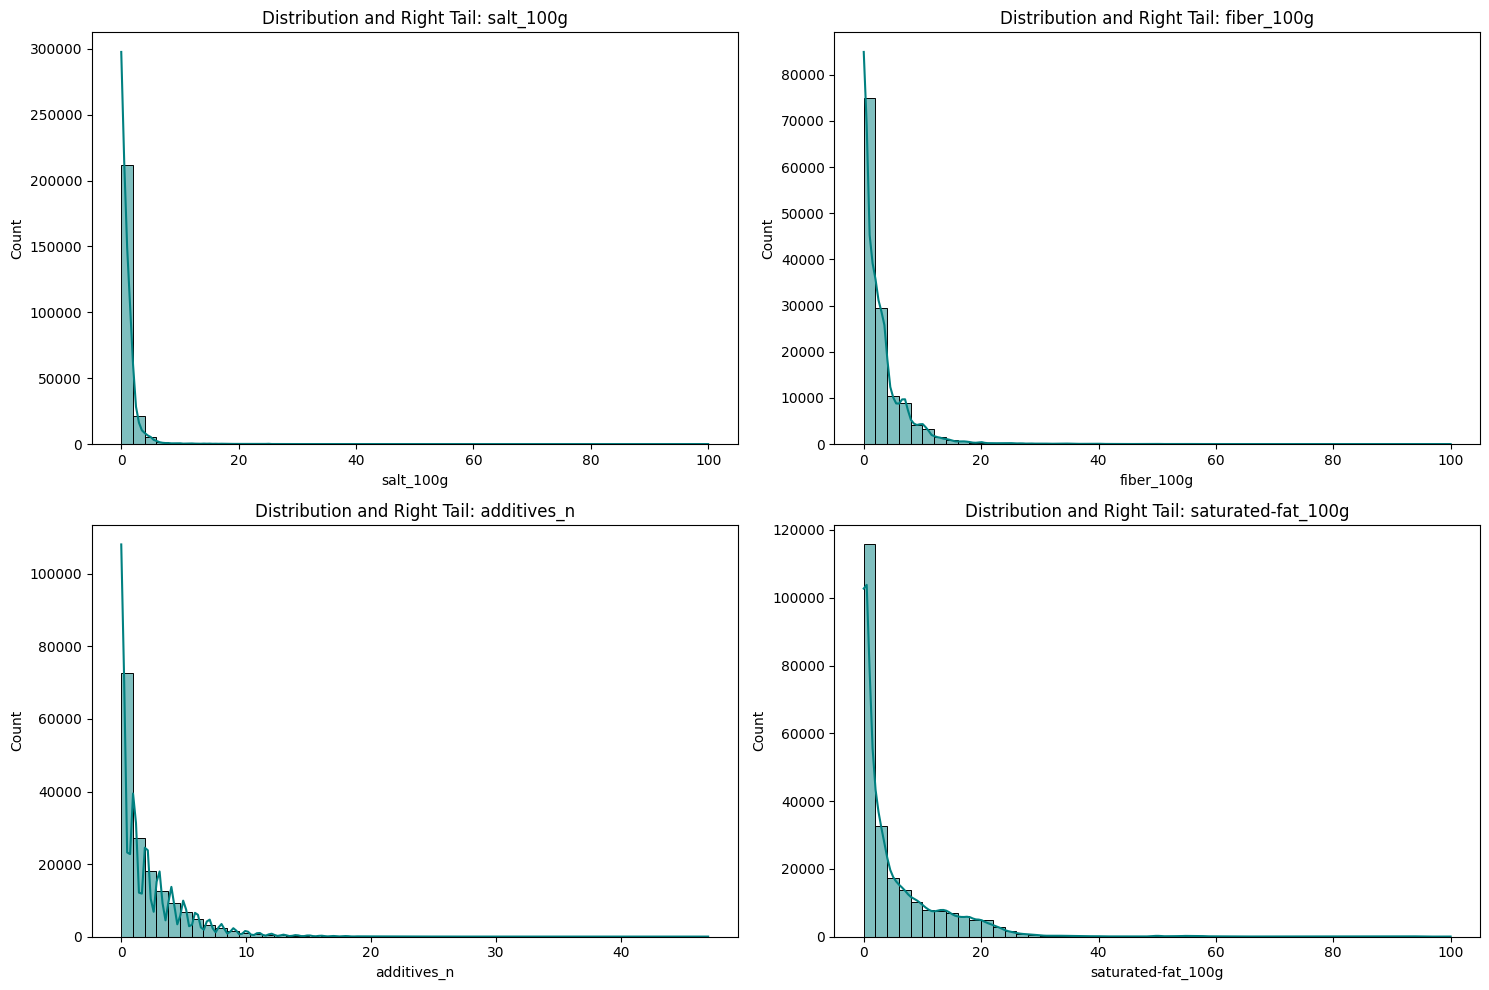

In [12]:
features = ['salt_100g', 'fiber_100g', 'additives_n', 'saturated-fat_100g']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Increased height for better plot visibility
axes = axes.flatten()  # Make sure axes is a flat array 

for i, col in enumerate(features):
    if col in df.columns:
        sns.histplot(
            data=df,
            x=col,
            kde=True,
            bins=50,
            color='teal',
            ax=axes[i],
            edgecolor='black'
        )
        axes[i].set_title(f'Distribution and Right Tail: {col}')
    else:
        axes[i].set_visible(False)  # Hide unused axes if col is missing

# If less features than axes, hide the rest
for j in range(len(features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**Positive skewness** is a structural characteristic of biochemical food composition. The distribution typically exhibits a dense mass near zero (**zero-inflation**) and an elongated right tail.

In the nutritional domain, this pattern is physiological: the vast majority of products contain minimal amounts of specific nutrients (e.g., `salt` or `fiber`), while only a small subset of specific categories (e.g., **concentrated sauces** or **whole-grain cereals**) possess high concentrations.


In [13]:
display(df[numerical_features].max())

energy_100g                            4200.00
energy-kcal_100g                       1000.00
fat_100g                                100.00
saturated-fat_100g                      100.00
carbohydrates_100g                      100.00
sugars_100g                             100.00
fiber_100g                              100.00
proteins_100g                           100.00
salt_100g                               100.00
sodium_100g                              40.00
fruits-vegetables-nuts_100g             100.00
fruits-vegetables-nuts-estimate_100g    100.00
additives_n                              47.00
dtype: float64

# Bivariate Analysis

We will now observe:

-the relationships between numerical features and the target variable **(Feature vs Target)**

-the relationships between numerical features **(Feature vs Feature)**

## Feature vs Target
Let's start by analyzing the boxplot of numerical feature against the nutriscore grade. 

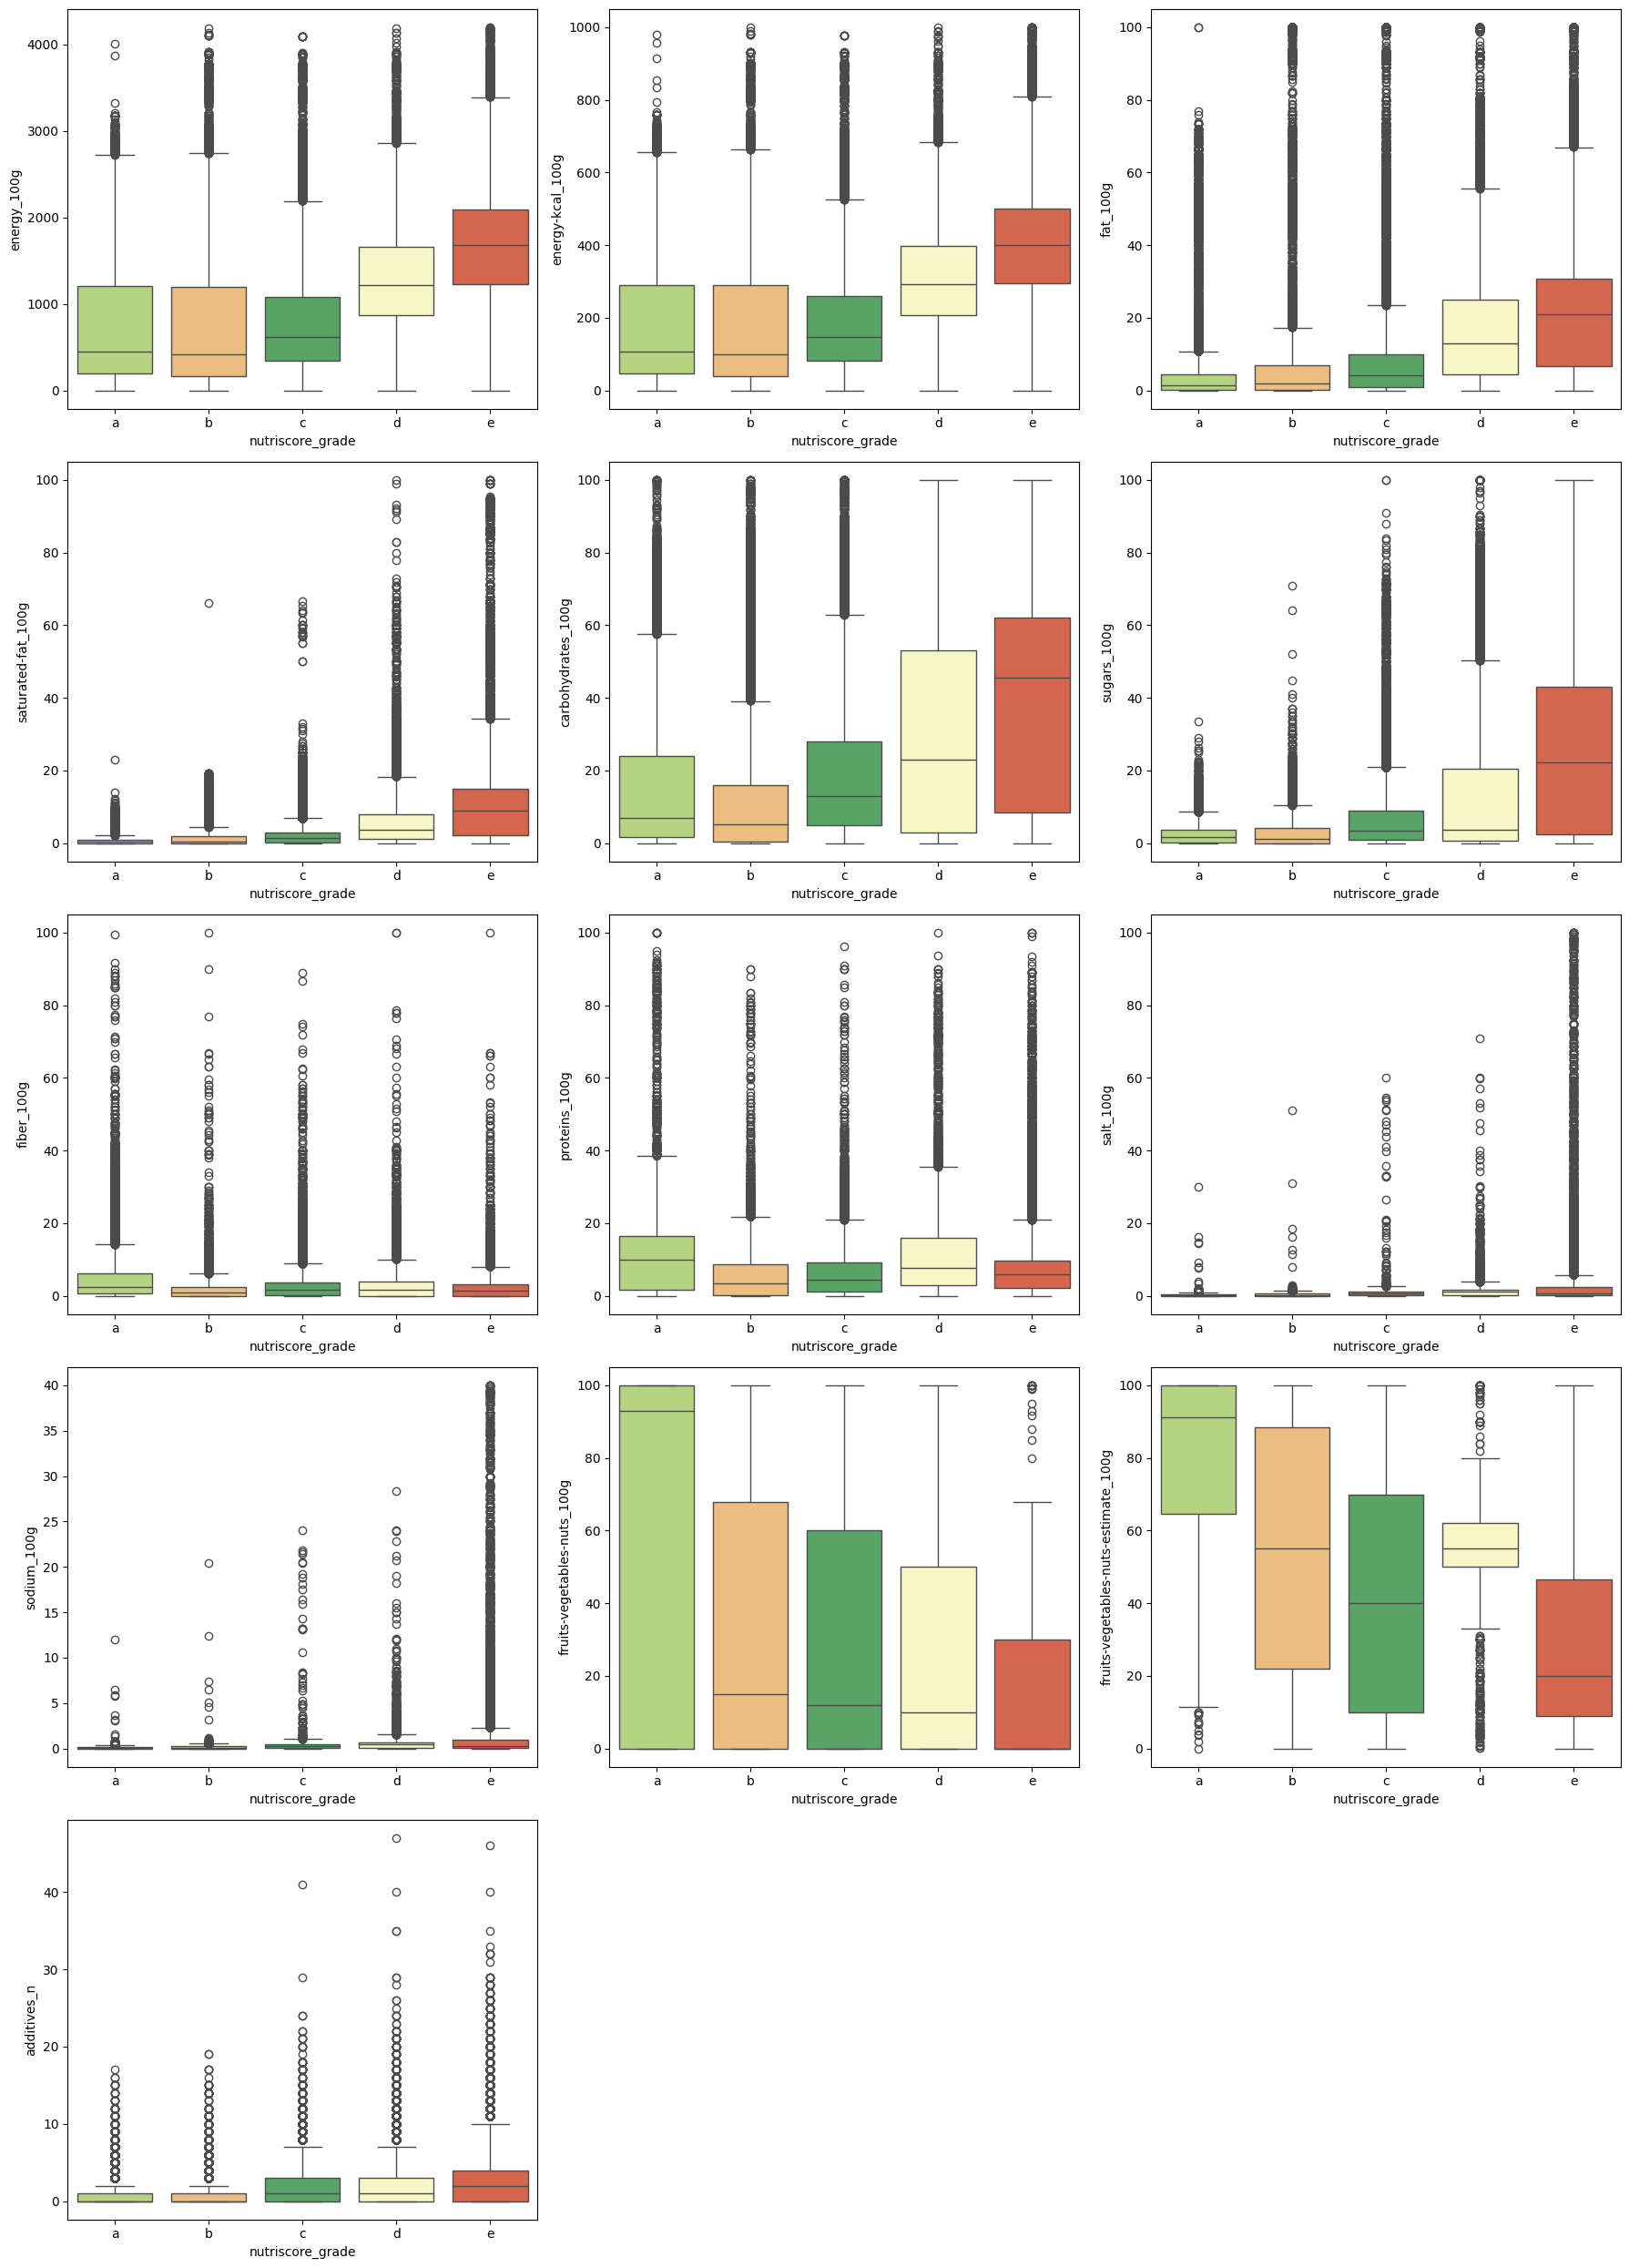

In [14]:
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_features):

    sns.boxplot(
        data=df, 
        x='nutriscore_grade',       
        y=col,            
        order=['a','b','c','d','e'],
        hue='nutriscore_grade',
        palette='RdYlGn_r',
        ax=axes[i]        
    )
# remove empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()



This boxplots give us some insight about the distribution of the numerical features against the target. 

The boxplot representation means:

* The colored box represent the IQR
* The line inside the box represent the median
* Whiskers extend from the box to the highest and lowest values within a specific range. 
In the standard Tukey boxplot, whiskers extend to the furthest data points within 1.5×IQR from the quartiles.
* Data points located beyond the whiskers are classified as outliers.

To have a better visualization we can plot the mean of the numerical features against the target.

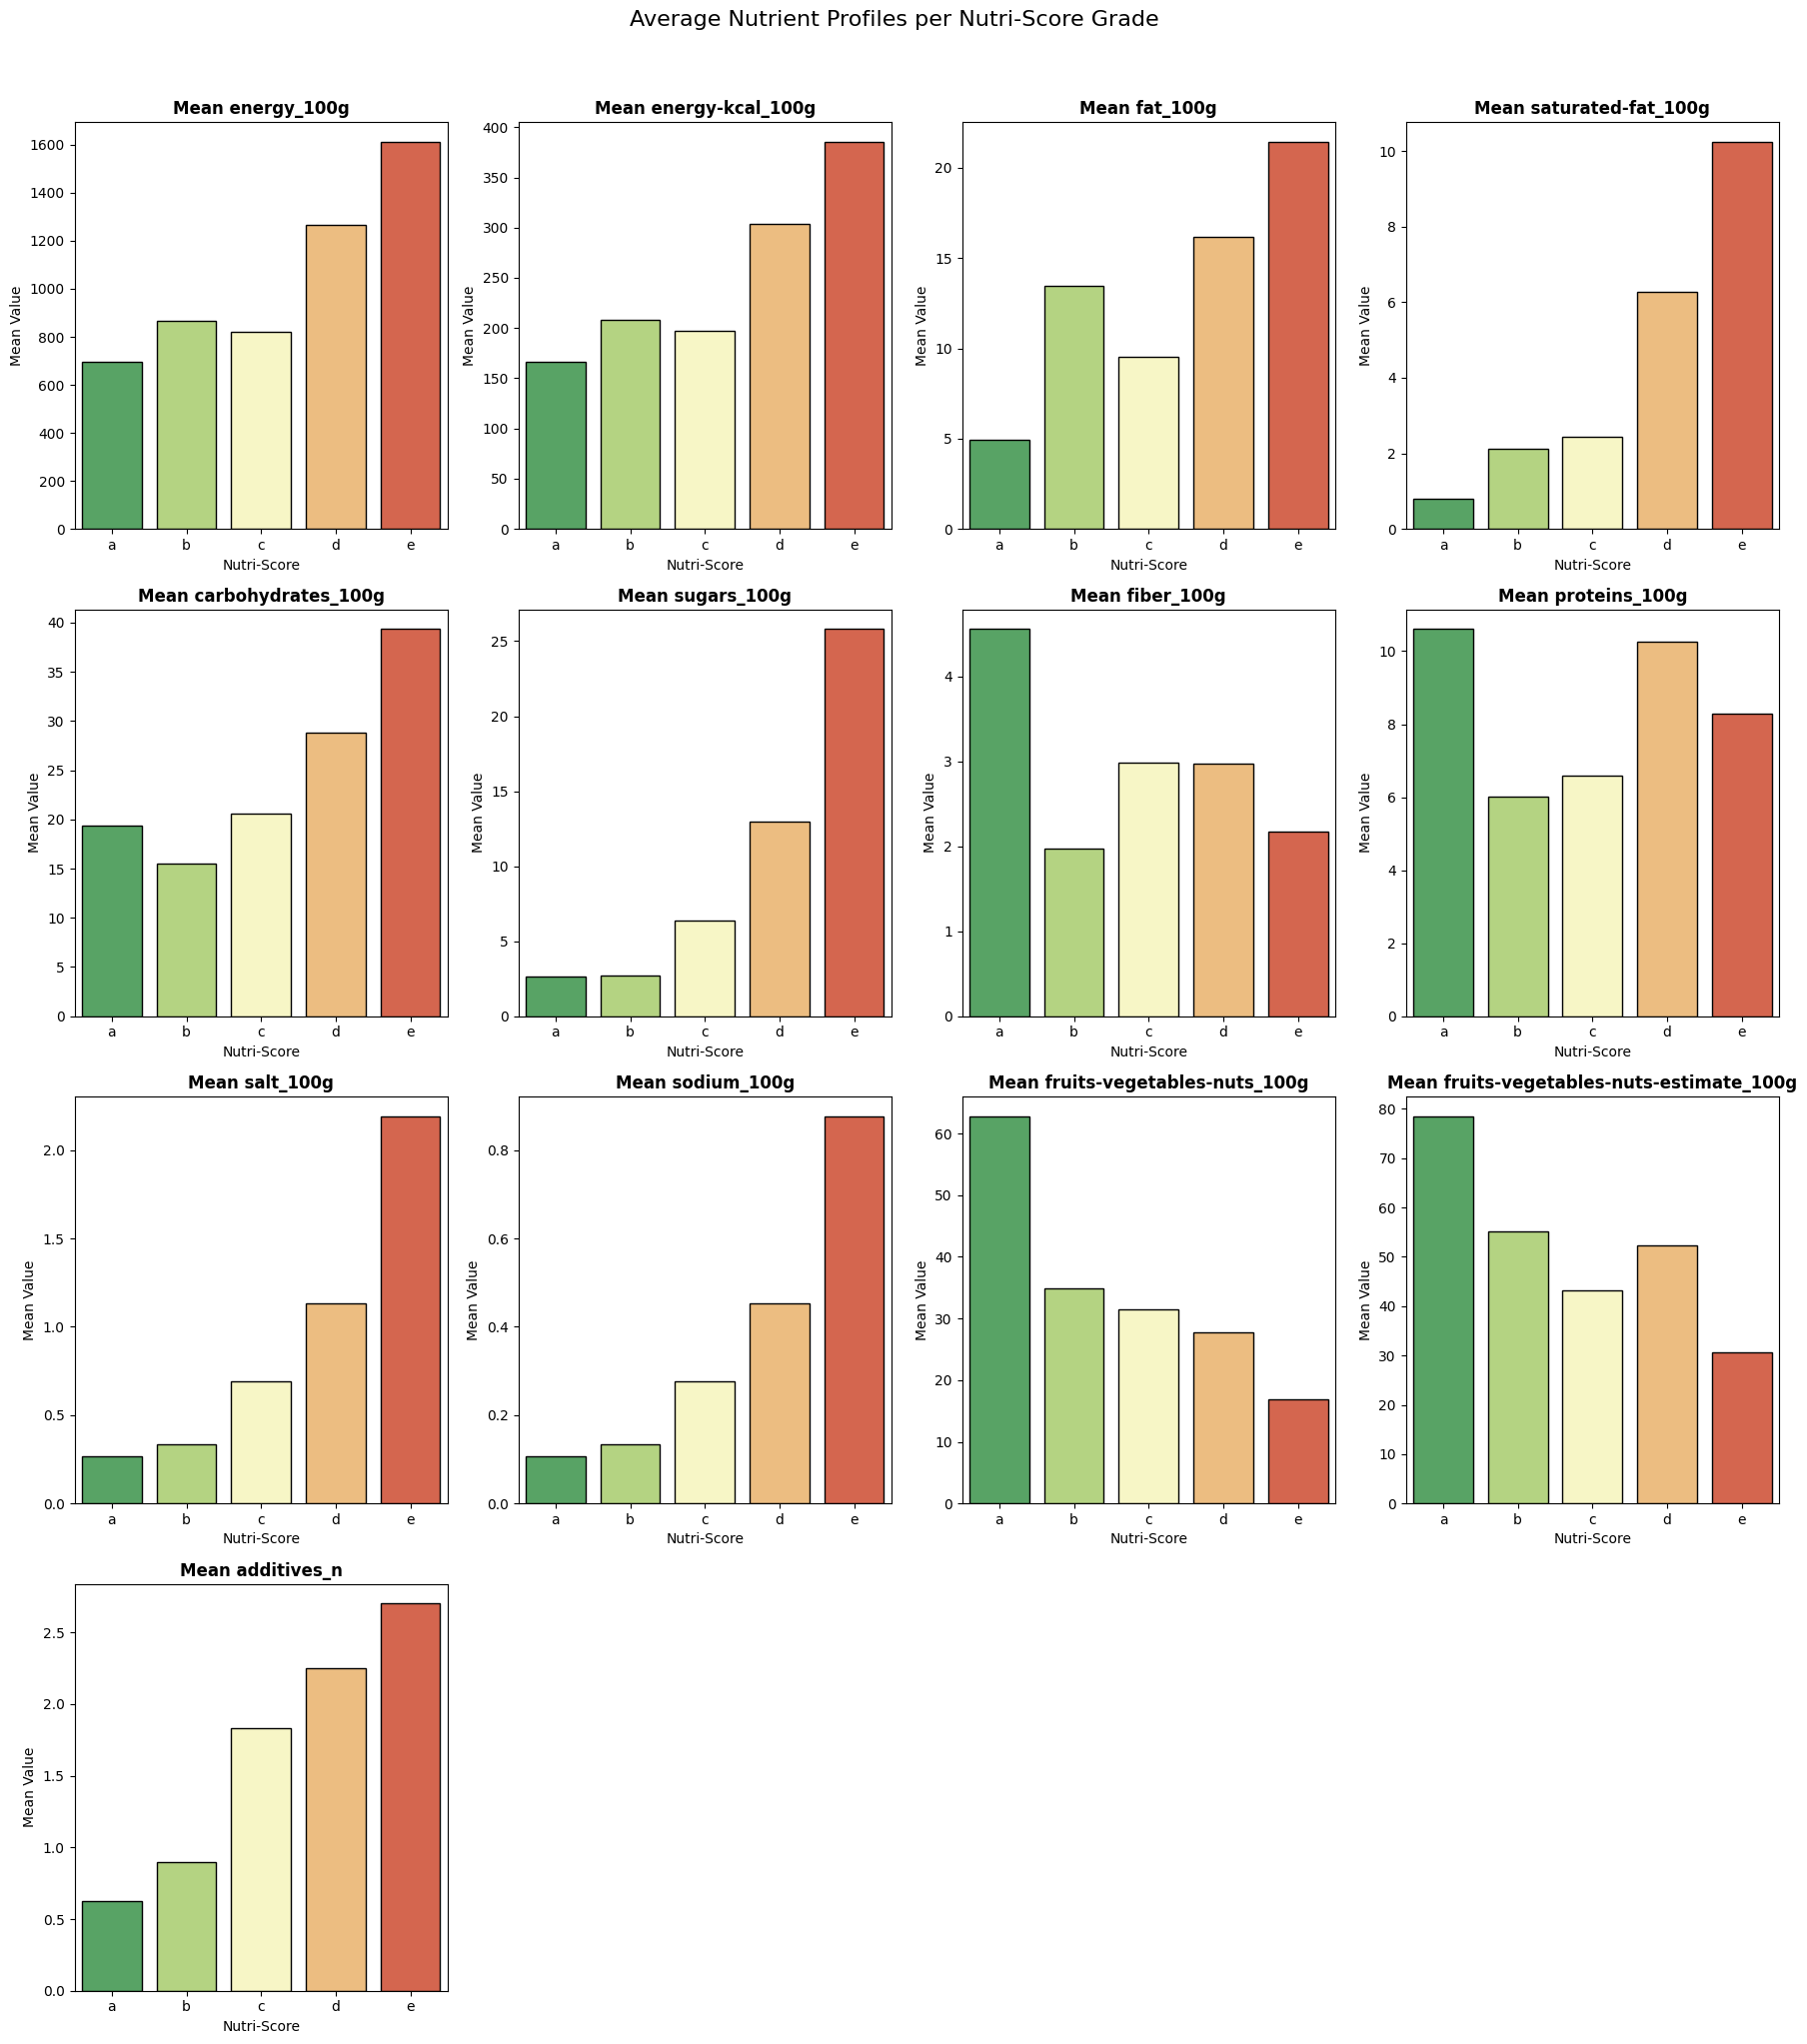

In [15]:
nutriscore_means = df.groupby('nutriscore_grade')[numerical_features].mean()

n_cols = 4
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.barplot(
        x=nutriscore_means.index,
        y=nutriscore_means[col],
        palette='RdYlGn_r',
        hue=nutriscore_means.index,
        ax=axes[i],
        edgecolor='black'    
    )
     
    axes[i].set_title(f'Mean {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Nutri-Score')
    axes[i].set_ylabel('Mean Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Average Nutrient Profiles per Nutri-Score Grade", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Feature vs Feature

First we plot the correlation matrix. In this case we decided to use the *Spearman* correlation because it is more sensitive to outliers.

We plot only the lower triangle to have a more clean visualization.

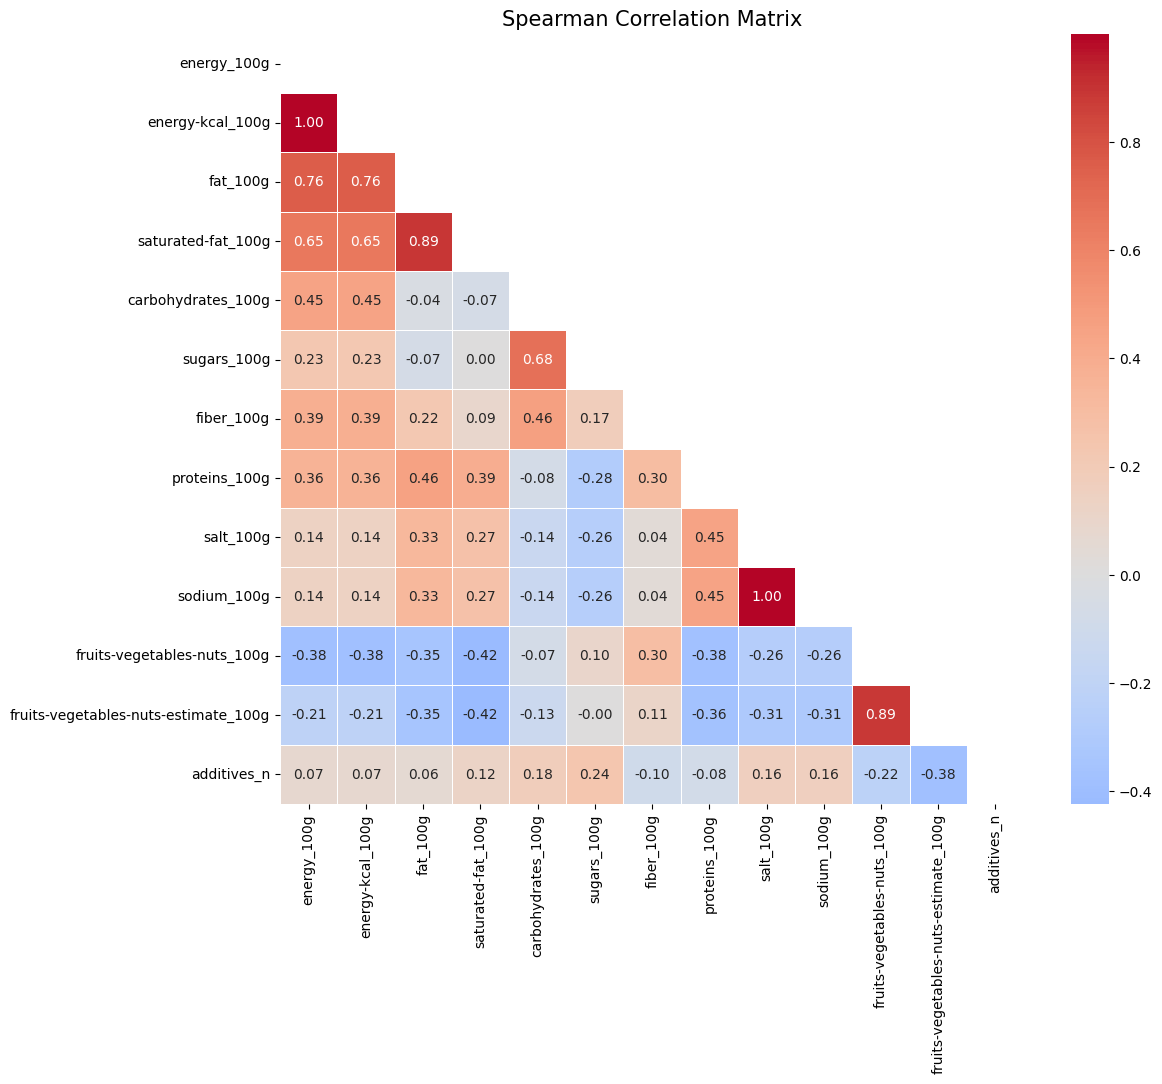

In [16]:
corr_matrix = df[numerical_features].corr(method='spearman')

# Hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True,          
    fmt=".2f",           
    cmap='coolwarm',    
    center=0,
    linewidths=0.5
)

plt.title('Spearman Correlation Matrix', fontsize=15)
plt.show()

If we analyze the matrix we see instantly that the most correlated features are:
- `energy_100g` and `energy-kcal_100g`
- `fat_100g` and `saturated-fat_100g`
- `sodium` and `salt`
- `fruits-vegetables-nuts_100g` and `fruits-vegetables-nuts-estimate_100g`

### Pairplot 

We now proceed with the pairplot of some of the numerical features against each other in a One vs One approach in order to better analyze
**feature interaction** and **class separation**

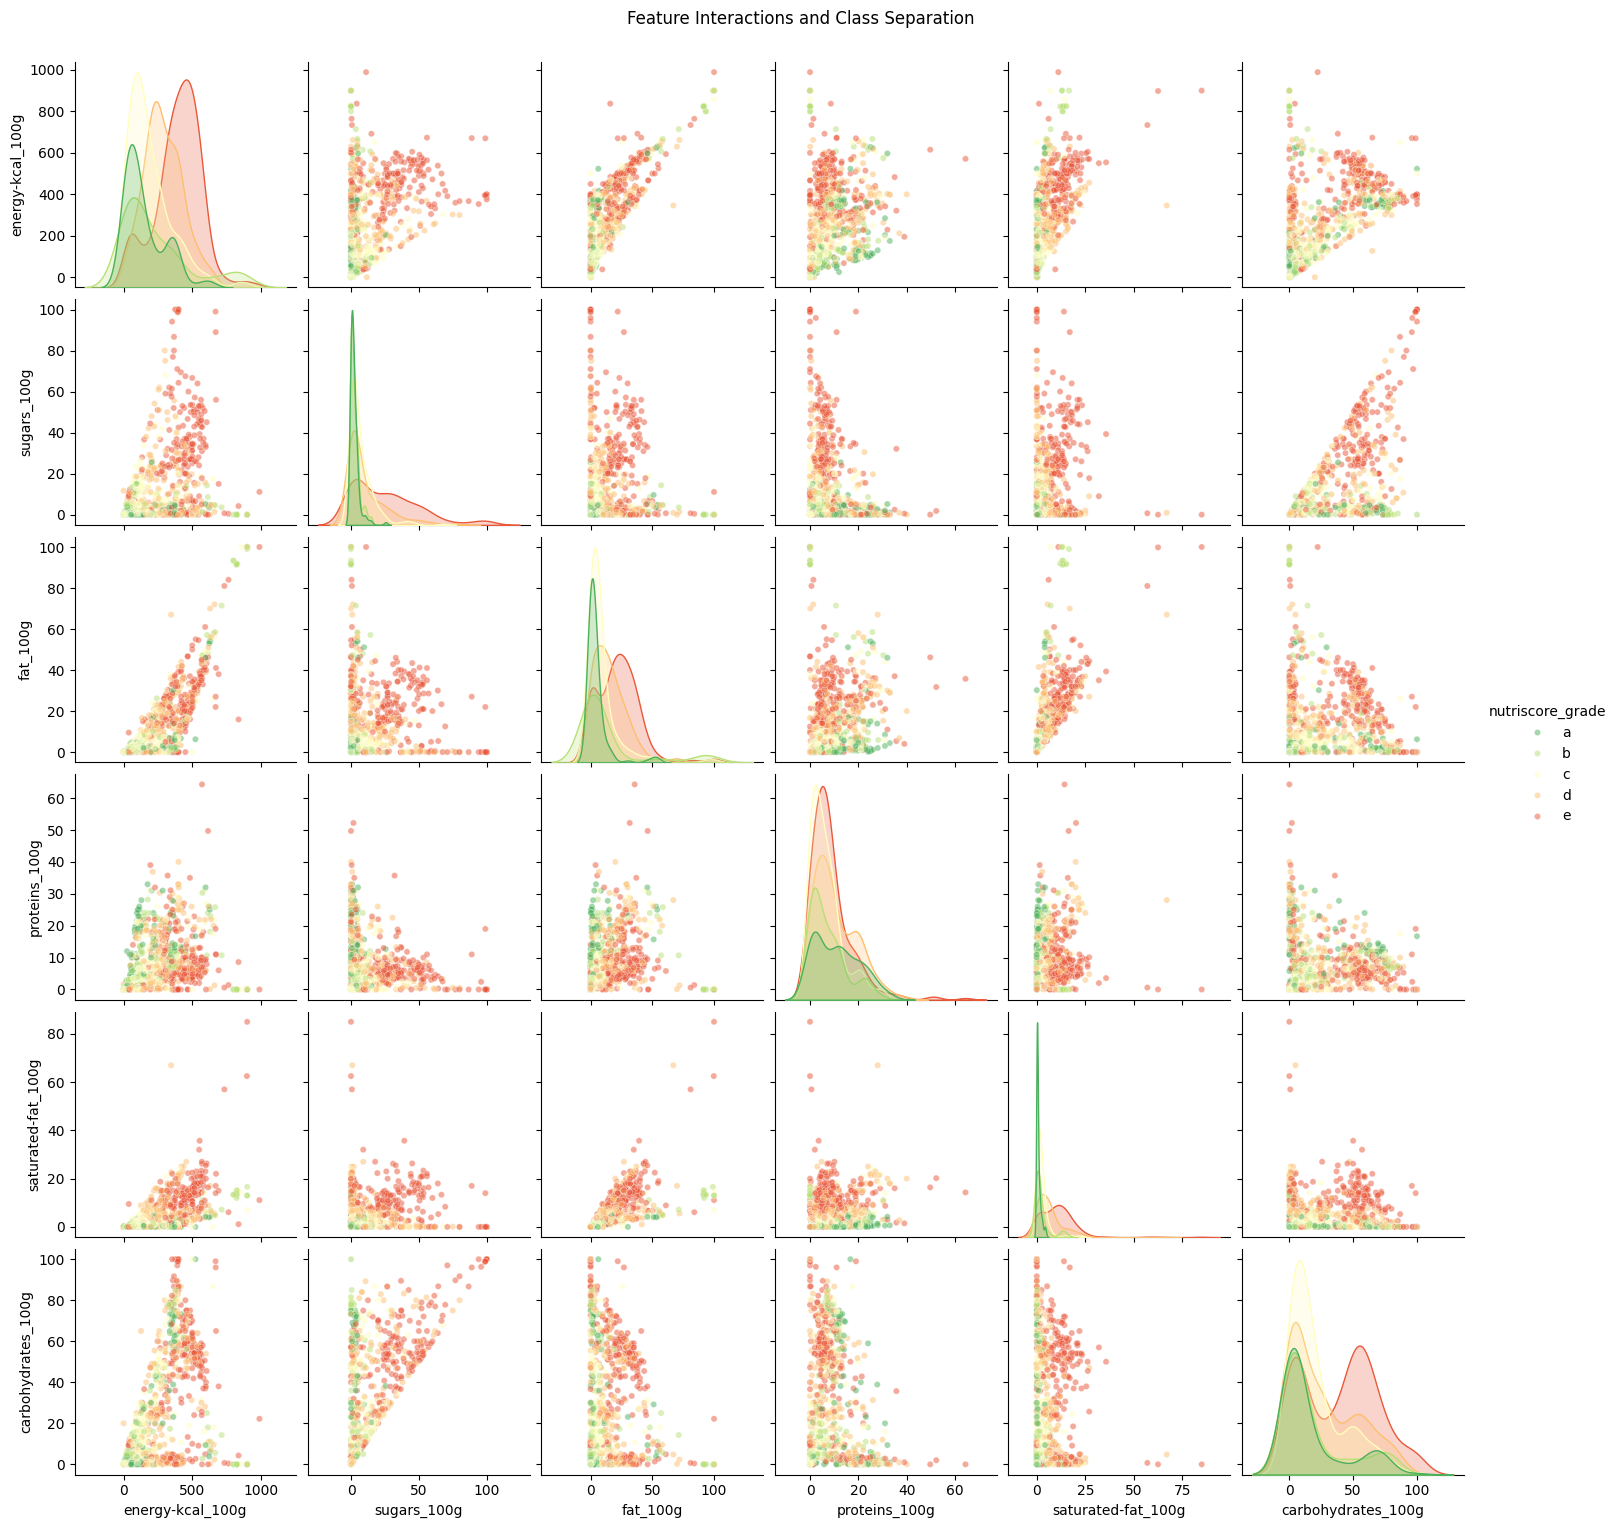

In [17]:
subset_features = ['energy-kcal_100g', 'sugars_100g', 'fat_100g', 'proteins_100g','saturated-fat_100g', 'carbohydrates_100g']

sns.pairplot(
    data=df.sample(1000),             
    vars=subset_features, 
    hue='nutriscore_grade',           
    hue_order=['a','b','c','d','e'],
    palette='RdYlGn_r',
    diag_kind='kde',                  
    plot_kws={'alpha': 0.5, 's': 20}  #
)

plt.suptitle('Feature Interactions and Class Separation', y=1.02)
plt.show()

# Categorical Features Analysis

Until this point we only analyzed numerical features. Now we focus on the **categorical features** in order to see if we can later find an encoding to avoid dropping them.
We will now:
- Check for missing values
- Compute missing values percentages
- Count unique values

In [18]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
if 'nutriscore_grade' in categorical_features: cat_cols = categorical_features.drop('nutriscore_grade')

summary = pd.DataFrame({
    'Unique': df[categorical_features].nunique(),
    'Nulls': df[categorical_features].isnull().sum(),
    'Null %': df[categorical_features].isnull().mean() * 100
}).sort_values('Null %', ascending=False)

display(summary)


,Unique,Nulls,Null %
brands,58785,52886,21.47
product_name,190463,4181,1.70
countries,5754,632,0.26
categories,70516,71,0.03
nutriscore_grade,5,0,0.00
code,246228,0,0.00
pnns_groups_1,11,0,0.00
pnns_groups_2,40,0,0.00
main_category,18373,0,0.00


Brands, Product, Name, categories and main_category all present a very high cardinality. An Encoding may not be possible if we want to avoid the **curse of dimensionality**.

Countries appears to have over 3000 values, but that is strange since there are only around 200 countries in the world.

We can focus on this 3 features:
- `pnns_groups_1`
- `pnns_groups_2`
- `countries`

In [19]:
print(df[['pnns_groups_1', 'pnns_groups_2', 'countries']].head())

             pnns_groups_1    pnns_groups_2          countries
0  Milk and dairy products  Milk and yogurt              Spain
1           Fish Meat Eggs             Meat          en:france
2  Milk and dairy products           Cheese             France
3                  unknown          unknown  en:United Kingdom
4     Cereals and potatoes            Bread      United States


`pnns_groups_1` and `pnns_groups_2` are both features that describe the category of the food and don't have a high cardinality

We can plot them against the target variable to have a better understanding of their importance

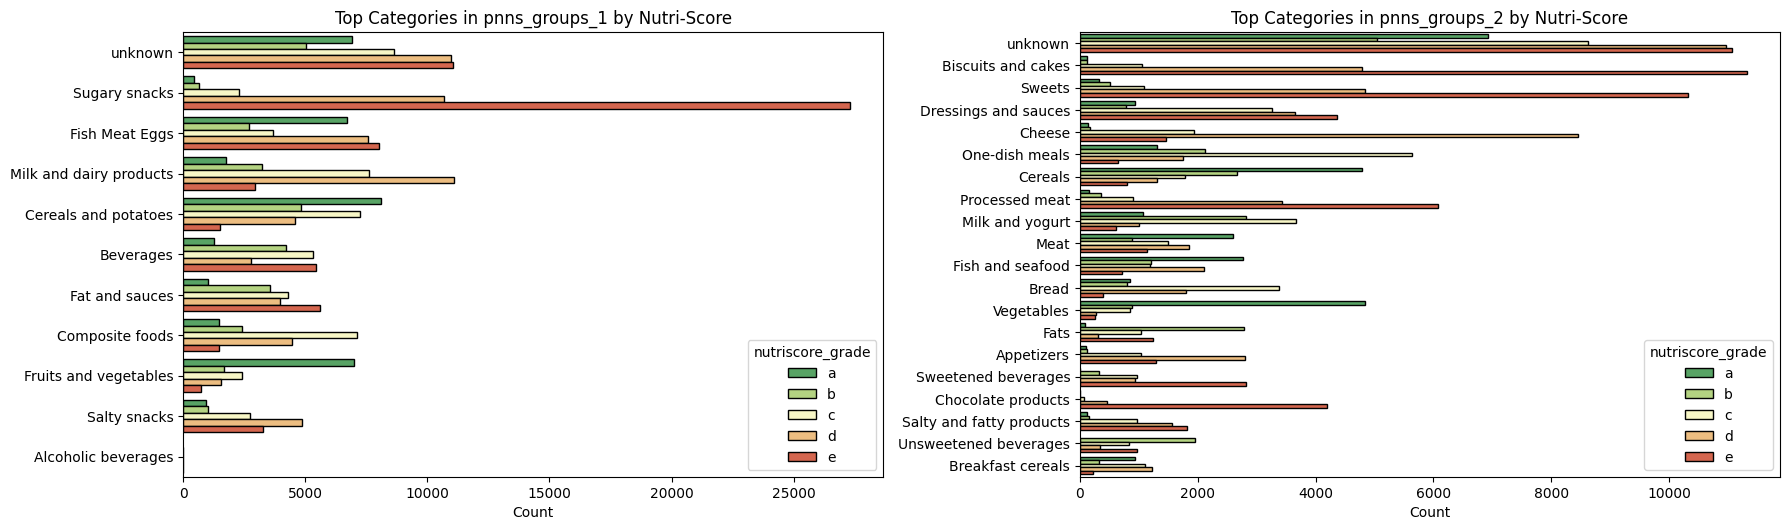

In [20]:
categorical_features = ['pnns_groups_1', 'pnns_groups_2']

n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    
    top_categories = df[col].value_counts().index[:20]
    df_filtered = df[df[col].isin(top_categories)]
    
    sns.countplot(
        data=df_filtered,
        y=col,
        hue='nutriscore_grade',
        hue_order=['a','b','c','d','e'],
        order=top_categories,
        palette='RdYlGn_r',
        ax=axes[i],
        edgecolor='black'
    )
    
    axes[i].set_title(f'Top Categories in {col} by Nutri-Score')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

# Remove empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



### DATA OVERVIEW:
- Dataset: **100,000 products** with **22 features**
- Target: **Nutri-Score** (a, b, c, d, e)
- Class imbalance:  
  - **A = 14.4%**
  - **B = 11.6%** (least common)
  - **C = 20.5%**
  - **D = 25.2%**
  - **E = 28.2%** (most common)  
-----------------------------
### DATA QUALITY ISSUES:
- **Extreme outliers**:  
  Some columns contain extreme outliers or negative numbers. They must be removed (probabilly wrong entries)
- **Missing data**:  

  `fruits-vegetables-nuts-estimate_100g`: More than **95% missing**, to be dropped.

  `fruits-vegetables-nuts_100g`: More than **95% missing**, to be dropped.

  `fiber_100g`: Around **45% missing** 

  `additives_n`: Around **35% missing**

- **Unrealistic values** : Many feature exceeds **100g per 100g** (physically impossible)
-----------------------------
### FEATURE INSIGHTS:
- **Energy-related features**: show strong relationship with Nutri-Score
- **Fat and saturated fat**: important predictors (higher values associated with worse grades)
- **Sugars and carbohydrates**: strong negative correlation with better grades
- **Salt/Sodium**: clear relationship with worse Nutri-Score grades
- **Fiber** good class separator (higher fiber associated with better grades)
-----------------------------
### CORRELATIONS :
- **Salt ~ Sodium**: **basically the same** 
- **Energy ~ Energy-kcal**: **Choose one and keep it**
- **Energy-kcal ~ Fat**: **high relationship**
- **Fat ~ Saturated-fat**

-----------------------------
### CATEGORY INSIGHTS:
- **PNNS Groups 1**: 11 categories
- **PNNS Groups 2**: 40 categories
- Different food categories show distinct Nutri-Score patterns
- Some categories naturally score better (e.g., Fruits and vegetables) or worse (e.g., Sugary snacks)
- Category features are **good predictors** for Nutri-Score
- **main_category, brand,**: Very high cardinality 
- **countries**: if filtered and processed correctly can be encoded as a feature (there are only around 200 countries in the world, we can use PyCountry library to maybe get a good result).

-----------------------------
